In [1]:
import shapefile

import osgeo.ogr as ogr
import osgeo.osr as osr

import whitebox

import laspy

from scipy import spatial
from scipy import ndimage as ndi

import numpy as np

import CSF

import rasterio
import rasterio.plot as rplt

from skimage import io,filters,util,img_as_uint,color,transform,img_as_ubyte, exposure
from skimage.transform import hough_line, hough_line_peaks
from skimage.morphology import disk, dilation, erosion, remove_small_objects,remove_small_holes
from skimage.measure import regionprops
import cv2

import matplotlib.pyplot as plt

import pandas as pd

import math
import imageio
import os

In [2]:
# Coordinate point ordering
def coor_sort_new(list_p):
    for i in range(len(list_p)):
        j=i
        for j in range(len(list_p)):
            if (list_p[i][0]<list_p[j][0]):
                list_p[i],list_p[j]=list_p[j],list_p[i]
            if (list_p[i][1]>list_p[j][1]):
                list_p[i],list_p[j]=list_p[j],list_p[i]
    if (list_p[0][1]>list_p[1][1]):
        left_top = list_p[0]
        right_top = list_p[1]
        left_bottom = list_p[2]
        right_bottom = list_p[3]
        
    else:
        left_top = list_p[1]
        right_top = list_p[0]
        left_bottom = list_p[3]
        right_bottom = list_p[2]
    sort_p = np.array([left_top,left_bottom,right_top,right_bottom], dtype="float64")
    return sort_p

In [3]:
sf = shapefile.Reader(r"C:\Users\Think\Desktop\test\mtps.shp",'rb')
shapes = sf.shapes()
list_p = []
num=0
for i in shapes:
    list_p.append(shapes[num].points[0])
    num+=1

geo_coords = coor_sort_new(list_p)

dataset = rasterio.open(r"C:\Users\Think\Desktop\test\chm.tif")

# Geographic coordinates are converted to pixel coordinates
upper_left_x, upper_left_y = (geo_coords[0][0],geo_coords[0][1])
upper_left_row, upper_left_col = dataset.index(upper_left_x, upper_left_y)
lower_left_x, lower_left_y = (geo_coords[1][0],geo_coords[1][1])
lower_left_row, lower_left_col = dataset.index(lower_left_x, lower_left_y)
upper_right_x, upper_right_y = (geo_coords[2][0],geo_coords[2][1])
upper_right_row, upper_right_col = dataset.index(upper_right_x, upper_right_y)
lower_right_x, lower_right_y = (geo_coords[3][0],geo_coords[3][1])
lower_right_row, lower_right_col = dataset.index(lower_right_x, lower_right_y)
columns_1 = np.int64(math.sqrt((upper_left_row-lower_left_row)**2
                              + (upper_left_col-lower_left_col)**2))
columns_2 = np.int64(math.sqrt((upper_right_row-lower_right_row)**2
                              + (upper_right_col-lower_right_col)**2))
columns_val = np.max((columns_1,columns_2))

rows_1 = np.int64(math.sqrt((upper_left_row-upper_right_row)**2
                           + (upper_left_col-upper_right_col)**2))
rows_2 = np.int64(math.sqrt((lower_left_row-lower_right_row)**2
                           + (lower_left_col-lower_right_col)**2))
rows_val = np.max((rows_1,rows_2))
dataset.close()
print(columns_val,rows_val)

2482 2241


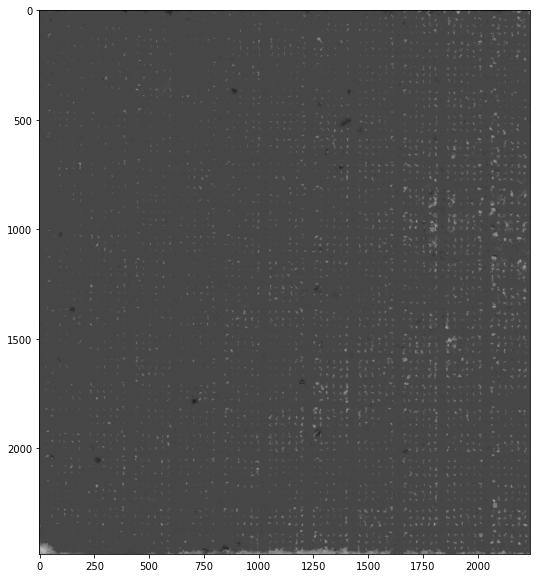

In [4]:
img_tif = io.imread(r"C:\Users\Think\Desktop\test\chm.tif")
    
pts1 = np.float32([[upper_left_col,upper_left_row],[upper_right_col,upper_right_row],[lower_left_col,lower_left_row],
                       [lower_right_col,lower_right_row]])
pts2 = np.float32([[0,0],[rows_val,0],[0,columns_val],[rows_val,columns_val]])
M_PT = cv2.getPerspectiveTransform(pts1,pts2)

dst_PT = cv2.warpPerspective(img_tif,M_PT,(rows_val,columns_val))

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(dst_PT,plt.cm.gray)

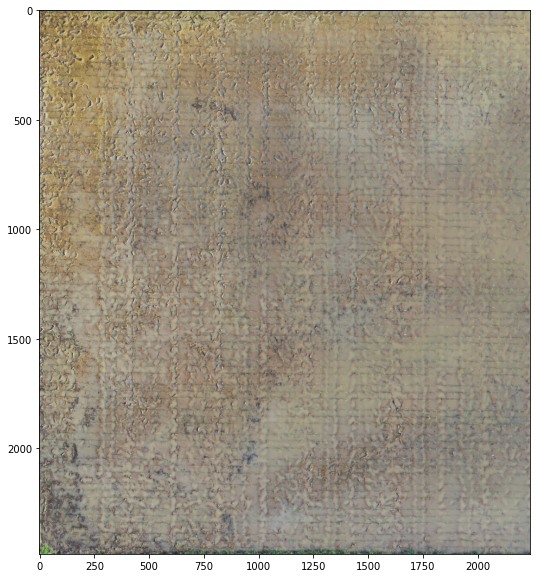

In [5]:
dataset_rgb = rasterio.open(r"C:\Users\Think\Desktop\test\orthomosaic.tif")

# Geographic coordinates are converted to pixel coordinates
upper_left_x, upper_left_y = (geo_coords[0][0],geo_coords[0][1])
upper_left_row, upper_left_col = dataset_rgb.index(upper_left_x, upper_left_y)
lower_left_x, lower_left_y = (geo_coords[1][0],geo_coords[1][1])
lower_left_row, lower_left_col = dataset_rgb.index(lower_left_x, lower_left_y)
upper_right_x, upper_right_y = (geo_coords[2][0],geo_coords[2][1])
upper_right_row, upper_right_col = dataset_rgb.index(upper_right_x, upper_right_y)
lower_right_x, lower_right_y = (geo_coords[3][0],geo_coords[3][1])
lower_right_row, lower_right_col = dataset_rgb.index(lower_right_x, lower_right_y)

img_rgb = io.imread(r"C:\Users\Think\Desktop\test\orthomosaic.tif")
    
pts1_rgb = np.float32([[upper_left_col,upper_left_row],[upper_right_col,upper_right_row],[lower_left_col,lower_left_row],
                       [lower_right_col,lower_right_row]])
pts2_rgb = np.float32([[0,0],[rows_val,0],[0,columns_val],[rows_val,columns_val]])
M_PT_rgb = cv2.getPerspectiveTransform(pts1_rgb,pts2_rgb)

dst_PT_rgb = cv2.warpPerspective(img_rgb,M_PT_rgb,(rows_val,columns_val))

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(dst_PT_rgb,plt.cm.gray)

242


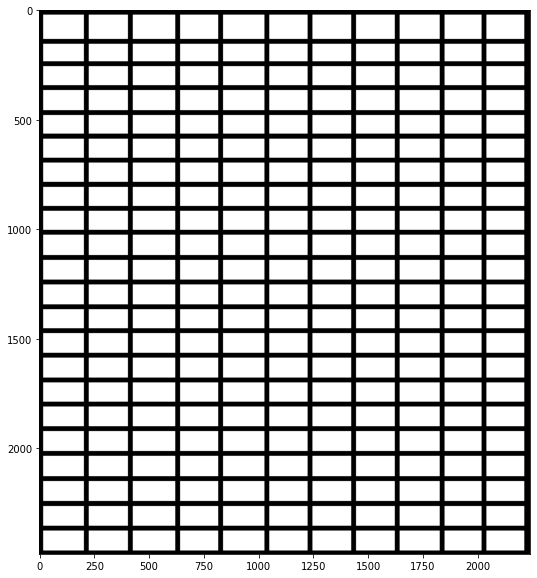

In [6]:
mask_line = io.imread(r"C:\Users\Think\Desktop\test\mask.png")
mask_line = transform.resize(mask_line,(columns_val,rows_val))

selem = disk(7)
Grid_Image = dilation(mask_line, selem)

Grid_Segment = np.logical_not(Grid_Image) 
Grid_Segment_Refine = erosion(Grid_Segment, disk(3))

list_bbox_area = []
Labelled_Plot_Img_o, num_features_o = ndi.measurements.label(Grid_Segment_Refine)
for region in regionprops(Labelled_Plot_Img_o):
    list_bbox_area.append(region.area)

re_area = np.max(list_bbox_area)*0.5
Grid_Segment_Refine = remove_small_objects(Grid_Segment_Refine, re_area)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(Grid_Segment_Refine, cmap=plt.cm.gray)

Labelled_Plot_Img, num_features = ndi.measurements.label(Grid_Segment_Refine)
print(num_features)

In [7]:
plot_id=0
for region in regionprops(Labelled_Plot_Img):
    minr, minc, maxr, maxc = region.bbox
    roi = dst_PT[minr:maxr,minc:maxc]
    dst_roi = (roi>np.percentile(roi,95))*1.0
    roi_rgb = dst_PT_rgb[minr:maxr,minc:maxc]
    imageio.imwrite(r"C:\Users\Think\Desktop\test\chm_plot_mask"+'\\'+"plot"+str(plot_id)+'.png', exposure.rescale_intensity(dst_roi.astype(np.uint8)))
    imageio.imwrite(r"C:\Users\Think\Desktop\test\rgb_plot"+'\\'+"plot"+str(plot_id)+'.png', roi_rgb)
    plot_id += 1

In [8]:
mask_path = os.listdir(r"C:\Users\Think\Desktop\test\chm_plot_mask")
mask_path = sorted(mask_path,key = lambda i:len(i),reverse=False)

list_seeding = []
for name in range(len(mask_path)):
    plot_mask0 = io.imread(r"C:\Users\Think\Desktop\test\chm_plot_mask"+'\\'+mask_path[name])
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 3))
    erosion_pm0 = cv2.erode(plot_mask0, kernel,iterations = 1)
    
    plot_rgb0 = io.imread(r"C:\Users\Think\Desktop\test\rgb_plot"+'\\'+mask_path[name])
    
    new_plot=plot_rgb0[:,:,:3] * (color.gray2rgb(erosion_pm0*255)).astype(np.uint8)

    plot_img_LAB = color.rgb2lab(new_plot)
    a_2D_Color_ND = plot_img_LAB[:, :, 1]

    b_2D_Color_ND = plot_img_LAB[:, :, 2] 
    LAB_Image_Ref = (b_2D_Color_ND - a_2D_Color_ND)

    global_thresh_Ref_Points_Value = filters.threshold_otsu(LAB_Image_Ref) 

    if global_thresh_Ref_Points_Value > 0 and global_thresh_Ref_Points_Value >= LAB_Image_Ref.max() * 0.425:
            binary_global_LAB = LAB_Image_Ref > LAB_Image_Ref.max() * 0.75 
    elif global_thresh_Ref_Points_Value > 0 and global_thresh_Ref_Points_Value < LAB_Image_Ref.max() * 0.425:  
            binary_global_LAB = LAB_Image_Ref > LAB_Image_Ref.max() * 0.35 
           
    else: 
            binary_global_LAB = LAB_Image_Ref > 0

    Img_cleaned = remove_small_objects(binary_global_LAB, 1) 
    selem = disk(3) 
    Img_cleaned_Dilated = dilation(Img_cleaned, selem)
    Img_cleaned_Ref = remove_small_holes(Img_cleaned_Dilated)
    erode_binary_Img = erosion(Img_cleaned_Ref, disk(2))
    erode_binary_Img = remove_small_objects(erode_binary_Img, 1) 

    Labelled_Plot_Img, num_features = ndi.measurements.label(erode_binary_Img)
    list_seeding.append(num_features)

In [9]:
dt = pd.DataFrame({'plot_id': plot_id, 'seedling_number': list_seeding})
dt.to_csv(r"C:\Users\Think\Desktop\test\seedling_number.csv",encoding="gbk")